# How to use DCAlign

First load package:


In [33]:
#using Pkg
#Pkg.activate("..")
#using DCAlign
include("../src/DCAlign.jl")
using DelimitedFiles
m = DCAlign

Main.DCAlign

### Load couplings and fields (J,h)

Using **DCAlign.read_parameters** it is possible to load the parameters of the Potts model.

You can choose between Boltzmann-machine learned parameters or Pseudo-likelihood ones. 
The function assumes that: 

    BM-learned parameters use the format J i j a b and h i a where '-' -> 0
    plm-learned parameters use the format J a b i j and h a i where '-' -> 21

Thus this must be specified in the variable _typel_ ("bm" , "plm") and in the variable _gap_ (0 or 21). 

Usage:
>J, h = DCAlign.read_parameters(file, q, L, gap=0, typel=Symbol("bm"))
    

In [24]:
## PF00677 ##
q = 21; L = 87; 
ctype=Symbol("amino")
typel=Symbol("bm")

J, H = DCAlign.read_parameters("../test/PF00677/Parameters_bm_PF00677potts.dat", q, L, gap=0, typel=typel);

Assuming J i j a b and h i a format
Output tersors: J[a b i j] and h[a i]
Gap in input file 0 now in 21


### Load sequences

The sub-routine **DCAlign.enveloptoalign** takes as input 
1. a full set of non-aligned sequences alone 
2. a full set of non-aligned sequences together with a known alignment in two formats (a standard MSA and one where insertions are added). 

All files should be written according to FASTA layout

Ex.

PF1_full.fasta 

    >Seq01
    SLSTAQLLQPSGGLQASVISNIVLMKGQAKGLGFSIVGGDSIYSPIGIYVRTIFAGRAAAADGRLQEGDEILELNGESMAGLTHQDALQKFK
    QAKKGLLTLTVRTRLTAPHALGGPLSPPLSRS

PF1_align.fasta

    >Seq01
    -IVLMKGQAKGLGFSIVGGDSIYSPIGIYVRTIFAGRAAAADGLQEGDEILELNGESMAGLTHQDALQKFKQAKKLLTLTVR

PF1_ins.fasta

    >Seq01
    -IVLMKGQAKGLGFSIVGGDSIYSPIGIYVRTIFAGRAAAADGrLQEGDEILELNGESMAGLTHQDALQKFKQAKKgLLTLTVR


You must also specify in _ctype_ the type of variables (amino-acids or nucleic bases) and, when the aligned sequences are added as input, the cut-off size _delta_ of the full length sequences (the final length will be _delta_ + _L_ + _delta_)

Usage
1. >seq = DCAlign.enveloptoalign("PF1_full.fasta", ctype=Symbol("amino"))
2. >seq = DCAlign.enveloptoalign("PF1_full.fasta", "PF1_align.fasta", "PF1_ins.fasta", delta = 20, ctype=Symbol("amino"))

In the last case _seq_ contains for all sequences in _i_ = 1,...,M
    
    seq[i][1] : name
    seq[i][2] : full length sequence
    seq[i][3] : aligned sequence
    seq[i][4] : aligned sequence with insertions


In [25]:
## PF00677 ##

delta = 50;
al = m.enveloptoalign( "../test/PF00677/PF00677.full", "../test/PF00677/PF00677.align", "../test/PF00677/PF00677.ins", delta = delta, ctype = ctype);
M = length(al)

# consider one random sequence as an example
idx0 = rand(1:M) 
(aux,garb) = split(al[idx0][1], "/")
seqhmm = al[idx0][3];
seqins = al[idx0][4];
seq = m.Seq(seqhmm,al[idx0][2],ctype)
N = length(al[idx0][2])
display(al[idx0][1])
display(al[idx0][2])
display(seqhmm)
display(seqins)



"A0A286TWQ1_9BACT/49-214"

"TVTQIKGTEVYFDVSRETLSKTNIGKLNVSDRVNIERSLKIGDKLGGHFVTGHVDCVGTINKIANETGQCTVWICVSNETTSMMIKKGSVAIDGISLTIVDLKEKLFSVALIPFTLDATTLGFKKAGQKVNIETDMLGKWVKRILTTNDTSSSEISEEMLKEKGFM"

"TGHVDCVGTINKIANETGQCTVWICVSETTSMMIKKG-SVAIDGISLTIV--DLKEKLFSVALIPFTLDATTLGFKKAGQKVNIETD"

"TGHVDCVGTINKIANETGQCTVWICVSnETTSMMIKKG-SVAIDGISLTIV--DLKEKLFSVALIPFTLDATTLGFKKAGQKVNIETD"

### Load insertions and gap penalties

You can simply read them from a text file.

In [26]:
## PF00677 ##
Lambda_all = readdlm("../test/PF00677/Lambda_PF00677.dat")
lambda_o = Lambda_all[:,1];
lambda_e = Lambda_all[:,2];


μext = 0.00;
μint = 2.00;

# Other data (!)

In [11]:
## Synthetic data ##
q = 5; L = 50; 
ctype=Symbol("nbase")
typel=Symbol("bm")

J, H = m.read_parameters("../test/Synthetic_potts/Parameters_bm_train_potts.dat", q, L, gap=0, typel=typel);

delta = 200;
al = m.enveloptoalign( "../test/Synthetic_potts/Test_potts.full", "../test/Synthetic_potts/Test_potts.align", "../test/Synthetic_potts/Test_potts.ins", delta = delta, ctype = ctype);
M = length(al)

# consider one random sequence as an example

idx0 = rand(1:M)

#testname = "SEQ42043"
testname = "SEQ41111"
for i in 1:M
    if occursin(testname, al[i][1])
        idx0 = i
        break
    end
end
(aux,garb) = split(al[idx0][1], "/")
seqhmm = al[idx0][3];
seqins = al[idx0][4];
seq = m.Seq(seqhmm,al[idx0][2],ctype)
N = length(al[idx0][2])
display(al[idx0][1])
display(al[idx0][2])
display(seqhmm)
display(seqins)

Lambda_all = readdlm("../test/Synthetic_potts/Lambda_train_potts.dat")
lambda_o = Lambda_all[:,1];
lambda_e = Lambda_all[:,2];


μext = 0.00;
μint = 0.00;

Assuming J i j a b and h i a format
Output tersors: J[a b i j] and h[a i]
Gap in input file 0 now in 5


ArgumentError: ArgumentError: range must be non-empty

In [20]:
## RF00059 ##
q = 5; L = 105; 
ctype=Symbol("nbase")
typel=Symbol("bm")

J, H = m.read_parameters("../test/RF00059/Parameters_bm_RF00059_potts.dat", q, L, gap=0, typel=typel);

delta = 100;
al = m.enveloptoalign( "../test/RF00059/RF00059.full", "../test/RF00059/RF00059_cm.fasta", "../test/RF00059/RF00059_cm.ins", delta = delta, ctype = ctype);
M = length(al)
println("Tot number of sequences ", M)
# consider one random sequence as an example
idx0 = rand(1:M) 
(aux,garb) = split(al[idx0][1], "/")
seqhmm = al[idx0][3];
seqins = al[idx0][4];
seq = m.Seq(seqhmm,al[idx0][2],ctype)
N = length(al[idx0][2])
println("Consider this sequence: ")
println(al[idx0][1])
println("Full length: ")
println(al[idx0][2])
println("Aligned by Infernal (without and with insertions): ")
println(seqhmm)
println(seqins)

Lambda_all = readdlm("../test/RF00059/Lambda_RF00059.dat")
lambda_o = Lambda_all[:,1];
lambda_e = Lambda_all[:,2];


μext = 0.00;
μint = 1.50;

Assuming J i j a b and h i a format
Output tersors: J[a b i j] and h[a i]
Gap in input file 0 now in 5
Tot number of sequences 12593
Consider this sequence: 
MKSU01000002.1/201920-201810
Full length: 
CACCTATCCCCGGGGGACCGCTGTCGCGGCGGTTGAGAGGAGGGCCGCAGCCCTCGACCCGCCGAACCTGATCCGGCTGACACCGGCGTAGGGAGGGAGCGGCGCAAACCT
Aligned by Infernal (without and with insertions): 
CACCUAUCCCCGGGGGACCGCUGUCGGCGGUUGAGAGGAGGGCCCCUC-GACCCGCCGAACCUGAUCCGGCUGACACCGGCGUAGGGAGGGAGCGGCGCAAACCU
CACCUAUCCCCGGGGGACCGCUGUcgCGGCGGUUGAGAGGAGGGCcgcagCCCUC-GACCCGCCGAACCUGAUCCGGCUGACACCGGCGUAGGGAGGGAGCGGCGCAAACCU


### Run DCAlign

Run advanced mean-field algorithm at a chosen temperature

In [34]:
# BP - large connectivity, (inv) temperature β, or β → + ∞ if T0 = true  (here put the parameter β = 1)
#include("../src/AlignPotts.jl");
#using Plots
#m = AlignPotts;
T0 = false
β = 1.0; μext = β * μext; μint = β * μint;
damp = 0.0
seed = 33
@time res=m.palign(seq, β.*J, β.*H, β.*lambda_o, β.* lambda_e, ctype = ctype ,mindec = 50, nprint=500, maxiter=2000, T0 = T0, μext=μext, μint =  μint,seed=seed, damp=damp, epsconv=1e-10 ,verbose=true); 

if !T0
    marg = deepcopy(res[3].pbf.P);
else
    marg = deepcopy(res[3].pbf.P);
    for i in 1:L
        h = exp.(marg[i])
        h .= h ./sum(h)
        marg[i] .= h
    end
    
end     
    
P = res[3].pbf.P 
out = m.decodeposterior(P, seq.strseq);
seqpa = out.pa # aligned seq 
seqpo = out.po # aligned seq with insertions
sat = m.check_assignment(P,true,N)
if sat == false
    (seqpa, P) = m.decimate_post(res[3],T0,idx0 = 1)
    out = m.decodeposterior(P, seq.strseq)
    seqpo = out.po
end
Ngap, Nins, Nb = m.count_gaps_ins(seqpo)
hdist, Gapp, Gapm, Sm = m.hammingdist(seqpa, seqhmm)
println("sol ", seqhmm)
println("mf  ", seqpa)
#println("mf ins", seqpo)
println("dist(mf, hmm) = ", hdist) 
en = m.compute_potts_en( J, H, seqpa, L,ctype)
enhmm = m.compute_potts_en( J, H, seqhmm, L,ctype)
seq_c = seqpa
println("(Potts) energy of mean-field approach ",en)
println("(Potts) energy of the solution ", enhmm)

println("mf ins:  ", seqpo)
println("sol ins: ", seqins)


println("mf cost function:  ", m.compute_cost_function(J,H,seqpo,L,ctype,lambda_o,lambda_e,μext,μint))
println("sol cost function: ", m.compute_cost_function(J,H,seqins,L,ctype,lambda_o,lambda_e,μext,μint))


Run Belief Propagation, large-connectivity approximation, for proteins alignment
L 87 = length of the Potts model
N 166 = length of the sequence A to be aligned
A: TVTQIKGTEVYFDVSRETLSKTNIGKLNVSDRVNIERSLKIGDKLGGHFVTGHVDCVGTINKIANETGQCTVWICVSNETTSMMIKKGSVAIDGISLTIVDLKEKLFSVALIPFTLDATTLGFKKAGQKVNIETDMLGKWVKRILTTNDTSSSEISEEMLKEKGFM
it = 33 -- en = -186.52 μext = 0.00 μint = 2.00 (ΔP,ΔB,ΔF) = 1.28e-12 4.17e-11 1.63e-12 
 68.167371 seconds (3.66 M allocations: 225.884 MiB, 0.08% gc time)
Let us check the assignment...
The subsequence satisfies the constraints
sol TGHVDCVGTINKIANETGQCTVWICVSETTSMMIKKG-SVAIDGISLTIV--DLKEKLFSVALIPFTLDATTLGFKKAGQKVNIETD
mf  -GHVDCVGTINKIANEG-QCTVWICVSETTSMMIKKG-SVAIDGISLTIV--DLKEKLFSVALIPFTLDATTLGFKKAGQKVNIETD
dist(mf, hmm) = 3
(Potts) energy of mean-field approach -196.45485200000053
(Potts) energy of the solution -190.99247000000054
mf ins:  -GHVDCVGTINKIANEtG-QCTVWICVSnETTSMMIKKG-SVAIDGISLTIV--DLKEKLFSVALIPFTLDATTLGFKKAGQKVNIETD
sol ins: TGHVDCVGTINKIANETGQC

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273


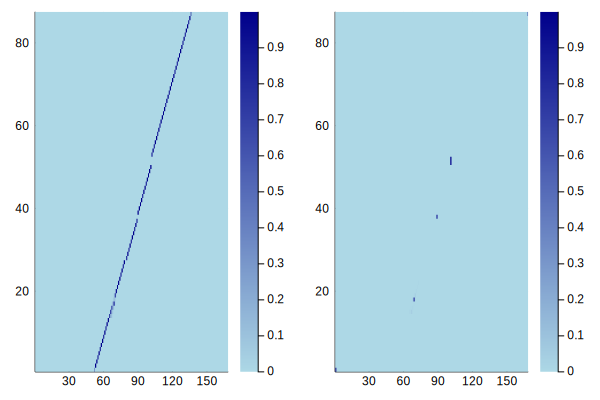

In [35]:
using Plots
N = length(seq.intseq)

M = zeros(L,N+2)

for i in 1:L
    h = marg[i]
    for n in 0:N+1
        M[i,n+1] = h[1,n]
    end
end

p1 = heatmap(M, c = :blues)
M = zeros(L,N+2)
for i in 1:L
    h = marg[i]
    for n in 0:N+1
        M[i,n+1] = h[0,n]
    end
end
p2 =  heatmap(M, c = :blues)
plot(p1,p2)


